# Introduction

In this project, we will be looking at the data from the communal bike sharing scheme in Washington D.C. The specific dataset was compiled by Hadi Fanaee-T at the University of Porto. [(download here)](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

Our goal will be to predict the total number of bikes people rented in a given hour (cnt). To accomplish this, we will be building a few different machine learning models and evaluating their performance.

Here is a brief description list of the relevant columns:
* instant- unique ID for each row of data
* dteday
* season
* yr
* mnth
* hr
* holiday
* weekday - day of week (0-7)
* workingday
* weathersit - categorical
* temp - on a 0-1 scale
* atemp - adjusted temperature
* hum - humidity, 0-1 scale
* windspeed - wind speed, 0-1 scale
* casual - number of casual riders (people who hadn't already signed up)
* registered - number of registered riders
* cnt - total number of bike rentals (casual + registered)

In [1]:
# read in dataset
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


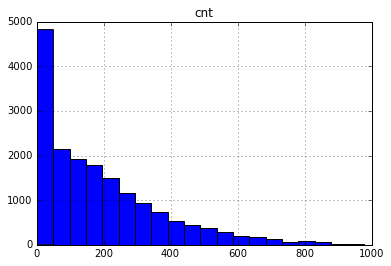

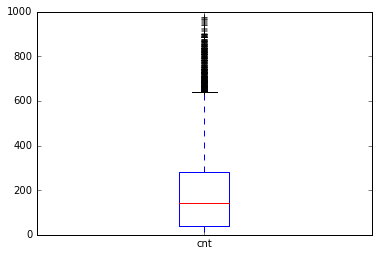

In [2]:
# run Jupyter magic function so that plots are displayed inline
%matplotlib inline

# make histogram of the cnt column to investigate distribution
bike_rentals.hist(column="cnt", bins=20)
bike_rentals.plot(y="cnt", kind="box")

From the histogram, we see that there are usually only 0-50 riders at any given hour. From the boxplot, we can see that the interquartile range is just shy of 700, with the median close to 100. This shows that this data is positively skewed.

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

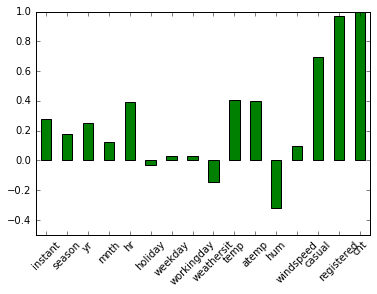

In [3]:
# use corr method of dataset to explore correlation between cnt and other variables
cnt_corr = bike_rentals.corr()['cnt']

cnt_corr.plot(kind="bar", ylim=[-0.5,1], color="green", rot=45)
cnt_corr

From the bar chart, we can see that the variables that are more correlated to our target are: hr, temp, atemp, hum, casual and registered.

As cnt is the sum of casual and registered, it is obvious that the correlation will be high. It is not recommended that either variable is used because there is a direct arithmatic relationship between these two features with the target, hence there will be strong issue with collinearity.

Other variables we can look in to are the hour of rental, temperature and humidity at the time of rentals.

## Calculating Features

Before inputing veriables into a machine learning model, it is often helpful to process the variables to be better suited for our specific needs, and it will improve the readability of our results.

We will look to convert 'hr' into a category variable with the following categories:
* 1 if hr is from 6-12
* 2 if hr is from 12-18
* 3 if hr is from 18-24
* 4 if hr is from 0-6

In [4]:
def assign_label(x):
    if 6 <= x < 12:
        return 1
    if 12 <= x < 18:
        return 2
    if 18 <= x <= 24:
        return 3
    if 0 <= x < 6:
        return 4
    
bike_rentals["time_label"] = bike_rentals["hr"].apply(lambda h: assign_label(h))

## Splitting the Data into Train and Test Sets

We split the dataset into train and test sets because after calculating model specification with the training set, we will need to test the model against the data from the test set to evaluate the accuracy of the model.

If a model is evaluated against the same data that it was trained on, the error value will be uncharacteristically low due to overfitting.

The error metric we will choose to evaluate the performance of the machine learning algorithms is the root mean squared error. We first find the mean squared error before taking root to calculate the sum of distances between each prediction from the actual values. An accurate model will provide better predictions, therefore the this metric will be low, and this is what we will aim when comparing between models.

In [5]:
# splitting dataset with 80% in train and the rest in test
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

After our initial data exploration, we find that the linear regression is likely to be a good model because many of the columns are highly correlated with our target.

We need to ignore casual and registered since cnt is derived from them, hence they are not independent from each other.

Linear regression models are more prone to underfitting than overfitting due to its model simplicity, hence a more robust selection might be beneficial in cases.

In [6]:
# selecting features
features = train.columns.drop(["cnt", "casual", "registered", "dteday",
                              "season", "mnth", "holiday", "weekday",
                              "workingday", "weathersit", "windspeed", "hr"])

# use linear regression class mfrom sklearn to train a model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# instantiate the model class
lr = LinearRegression()

# train model with feature on target
lr.fit(train[features], train["cnt"])
# test model on test dataset
predictions = lr.predict(test[features])

# calculate RMSE of model
lr_mse = mean_squared_error(test["cnt"], predictions)
lr_rmse = np.sqrt(lr_mse)

lr_rmse

139.37209055850136

We have opted to keep variables with higher correlations, which is approximately above an aribitary 0.4 and below -0.3 threshold, and dropped all other features.

We then fitted the data on a linear regerssion model and calculated the root mean squred error.

## Applying Decision Trees

Now we will apply the decision tree algorithm. We expect a lower error value compared to the linear regression model because decision trees tend to predict outcomes much more reliably than linear regression models.

As a fairly complex model, decision trees are more prone to overfitting, hence we should pay special attention to the hyperparameter adjustments for such models (max depth, min number of samples per leaf... etc). They are also more suspectable to instability, where small changes to the input data can result in a vastly different output model.

In [7]:
# fit a decision tree algorithm to train data
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test["cnt"], predictions)
dtr_rmse = np.sqrt(dtr_mse)

dtr_rmse

139.25638035887593

In [8]:
# adjusting specifications in the algorithm to improve model
dtr_adj_rmse = []
# min samples leaf
dtr = DecisionTreeRegressor(min_samples_leaf=10)

dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test["cnt"], predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_adj_rmse.append(dtr_rmse)

# max depth
dtr = DecisionTreeRegressor(max_depth=3)

dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test["cnt"], predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_adj_rmse.append(dtr_rmse)

# min samples leaf, max depth
dtr = DecisionTreeRegressor(min_samples_leaf=10, max_depth=3)

dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test["cnt"], predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_adj_rmse.append(dtr_rmse)

# min samples leaf
dtr = DecisionTreeRegressor(min_samples_leaf=30)

dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test["cnt"], predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_adj_rmse.append(dtr_rmse)

dtr_adj_rmse

[122.96890070679838,
 132.02185180433452,
 132.02185180433452,
 120.36983761908913]

We find that the error from the default algorithm is higher than that of the linear regression model. As explained previously, we suspect this is due to the algorithm being overfitted, hence we will adjust a few parameters to try and improve the model.

We choose to set the minimum number of samples in each leaf to 10 and max depth to 3, and found that the best model is when we adjust min sample per leaf to be larger than the default 1. Adjustments to max depth was actually counterproductive, and this is because we have only selected 6 features to train our models on, hence max depth for the algorithm is already quite restricted.

The model with the lowest error is the model where we set min sample count at 30 per leaf.

## Applying Random Forests

We will now move on to applying random forest algorithm, which in essence is an average of many decision trees. This method improves on the decision tree algorithm because they usually overfit less than decision trees, but are more complex than simple linear regression.

However, random forest models are still prone to overfitting, so it is important to improve the model by tuning the parameters.

In [9]:
# fit a random forest algorithm to train data
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf.fit(train[features], train["cnt"])
predictions = clf.predict(test[features])
clf_mse = mean_squared_error(test["cnt"], predictions)
clf_rmse = np.sqrt(clf_mse)
clf_rmse

112.8005906876984

In [10]:
# tune parameters of random forest for improvement
clf_adj_rmse = []

# min sample leaves
clf = RandomForestRegressor(min_samples_leaf=20)
clf.fit(train[features], train["cnt"])
predictions = clf.predict(test[features])
clf_mse = mean_squared_error(test["cnt"], predictions)
clf_rmse = np.sqrt(clf_mse)
clf_adj_rmse.append(clf_rmse)

# min sample leaves
clf = RandomForestRegressor(min_samples_leaf=30)
clf.fit(train[features], train["cnt"])
predictions = clf.predict(test[features])
clf_mse = mean_squared_error(test["cnt"], predictions)
clf_rmse = np.sqrt(clf_mse)
clf_adj_rmse.append(clf_rmse)

# number of trees to fit
clf = RandomForestRegressor(n_estimators=200)
clf.fit(train[features], train["cnt"])
predictions = clf.predict(test[features])
clf_mse = mean_squared_error(test["cnt"], predictions)
clf_rmse = np.sqrt(clf_mse)
clf_adj_rmse.append(clf_rmse)

clf_adj_rmse

[116.08425053458994, 117.70170836173475, 108.30459618676561]

We tried tuning the minimum of samples per leaf, as well as the number of trees to estimate before averaging to find avearge error.

We found that the default parameters are most suitable for our case. This is because even if we were able to improve the model with higher number of trees in the forest, the computational effort is visibly higher and hence not the most efficient model. Increasing number of samples per leaf does not seem to improve the model in this case.

## Conclusion

We have used three algorithms to predict the number of rental bikes that were borrowed at a given hour. We were able to improve the prediction accuracy as we increase the complexity of the algorithm adopted. However, this is only true up to certain point, beyond such, the model will be overfitted and accuracy of the predictions will decrease.

We were able to also make adjustments to the model parameters to reduce the error metric.

## Potential next steps:
* calculate additional features
    * further processing of chosen features
* change target variable from cnt to causal and/or registered